In [1]:
import urllib.parse

import geopandas as gpd
import pandas as pd

In [16]:
output_path = "Japan_earthquake_analysis"

In [3]:
CATALOG_URL = "https://earthquake.usgs.gov/fdsnws/event/1/query.geojson"

maxlatitude= 46.0
minlatitude=30.0
maxlongitude = 146.0
minlongitude = 129.0
minmagnitude = 4.5

params_japan = {
    "format": "geojson",
    "starttime": "2024-01-01",
    "endtime": "2024-12-31",
    "minlatitude": 30.0,
    "maxlatitude": 46.0,
    "minlongitude": 129.0,
    "maxlongitude": 146.0,
    "minmagnitude": 4.5,
}

params = {
    "starttime": "2024-01-01",
    "endtime": "2024-12-31",
    "maxlatitude": 46.0,
    "minlatitude": 30.0,
    "maxlongitude": 146.0,
    "minlongitude": 129.0,
    "minmagnitude": 4.5,
    "eventtype": "earthquake",
    "orderby": "time",
}
columns = ["mag", "time", "geometry"]

In [4]:
url = f"{CATALOG_URL}?{urllib.parse.urlencode(params)}"
quakes = gpd.read_file(url, columns=columns)

In [5]:
# get the national boundary of Japan
boundary_url = "https://media.githubusercontent.com/media/wmgeolab/geoBoundaries/refs/heads/main/releaseData/gbOpen/JPN/ADM0/geoBoundaries-JPN-ADM0.geojson"
japan = gpd.read_file(boundary_url)

In [6]:
# ensure both dataframes are in the same CRS
quakes = quakes.to_crs(japan.crs)

# filter earthquakes to those within Japan's boundaries
quakes = quakes[quakes.within(japan.iloc[0]['geometry'])]

In [7]:
quakes

,mag,time,geometry
7,4.6,1734854151387,POINT Z (130.6312 31.845 170.684)
9,4.5,1734441078418,POINT Z (139.9292 36.2615 76.086)
17,4.5,1733611184842,POINT Z (140.108 35.5123 74.306)
19,4.8,1733462760960,POINT Z (131.3993 31.8623 63.021)
41,4.7,1731693531265,POINT Z (140.7467 35.8011 50.526)
...,...,...,...
312,4.6,1704094095144,POINT Z (136.8046 37.3496 10)
313,4.6,1704094048747,POINT Z (137.2254 37.3802 10)
314,6.2,1704093521584,POINT Z (136.8272 37.1895 10)
315,7.5,1704093009476,POINT Z (137.271 37.4874 10)


In [8]:
quakes["time"] = pd.to_datetime(quakes["time"], unit="ms").dt.tz_localize(
    tz="UTC"  # First localize to UTC if not already timezone-aware
).dt.tz_convert("Asia/Tokyo")

In [9]:
# for working with matplotlib, add separate latitude/longitude columns
quakes = quakes.join(
    quakes.get_coordinates().rename(columns=dict(y="latitude", x="longitude"))
)

In [10]:
quakes

,mag,time,geometry,longitude,latitude
7,4.6,2024-12-22 16:55:51.387000+09:00,POINT Z (130.6312 31.845 170.684),130.6312,31.8450
9,4.5,2024-12-17 22:11:18.418000+09:00,POINT Z (139.9292 36.2615 76.086),139.9292,36.2615
17,4.5,2024-12-08 07:39:44.842000+09:00,POINT Z (140.108 35.5123 74.306),140.1080,35.5123
19,4.8,2024-12-06 14:26:00.960000+09:00,POINT Z (131.3993 31.8623 63.021),131.3993,31.8623
41,4.7,2024-11-16 02:58:51.265000+09:00,POINT Z (140.7467 35.8011 50.526),140.7467,35.8011
...,...,...,...,...,...
312,4.6,2024-01-01 16:28:15.144000+09:00,POINT Z (136.8046 37.3496 10),136.8046,37.3496
313,4.6,2024-01-01 16:27:28.747000+09:00,POINT Z (137.2254 37.3802 10),137.2254,37.3802
314,6.2,2024-01-01 16:18:41.584000+09:00,POINT Z (136.8272 37.1895 10),136.8272,37.1895
315,7.5,2024-01-01 16:10:09.476000+09:00,POINT Z (137.271 37.4874 10),137.2710,37.4874


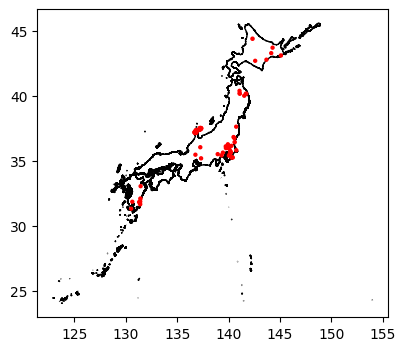

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6,4))
japan.plot(color="white", edgecolor="black", ax=ax)
quakes.plot(ax=ax, markersize='mag', color="red")
plt.show()

In [14]:
base_size = 10
base_magnitude = 5
quakes["marker_size"] = base_size * (10 ** (quakes["mag"] - base_magnitude))

In [ ]:
# pip install contextily

In [17]:
import contextily as cx
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(layout="constrained", figsize=(6,5))
ax.set(xlim=[minlongitude, maxlongitude], ylim=[minlatitude, maxlatitude])
ax.set_title("The January 2024 Nepal earthquake and its aftershocks")
# add basemap
cx.add_basemap(ax, crs=quakes.crs, zoom=8, source="CartoDB.Voyager")

# the first point in the animation
points_opts = dict(alpha=0.5, linewidth=0, color="red")
points = ax.scatter(
    quakes["longitude"].iloc[0],
    quakes["latitude"].iloc[0],
    s=quakes["marker_size"].iloc[0],
    **points_opts
)

# the first label
# labels show the time of the earthquake
label_opts = dict(ha="center", va="center", fontsize=15, color="black", transform=ax.transAxes)
label = ax.text(
    0.25,
    0.95,
    quakes["time"].iloc[0].strftime("%Y-%m-%d %H:%M"),
    **label_opts
)

# loop through each point in the data and draw a marker and legend for that data point
def update(frame):
    # for each frame, update the data stored on each artist.
    x = quakes["longitude"].iloc[:frame]
    y = quakes["latitude"].iloc[:frame]

    # update the scatter plot:
    data = np.stack([x, y]).T
    points.set_offsets(data)

    # set the size of the earthquakes
    points.set_sizes(quakes["marker_size"].iloc[:frame])

    # update the label
    label.set_text(quakes["time"].iloc[frame - 1].strftime("%Y-%m-%d %H:%M"))

    return (points,)

# animate by looping through all datapoints.
ani = animation.FuncAnimation(
    fig=fig, func=update, frames=len(quakes), interval=600
)

# To save the animation using Pillow as a gif
writer = animation.PillowWriter(fps=10, bitrate=1800)
ani.save(output_path + "/japan_animated-scatter-v1.gif", writer=writer)

plt.show
plt.ioff
plt.close()

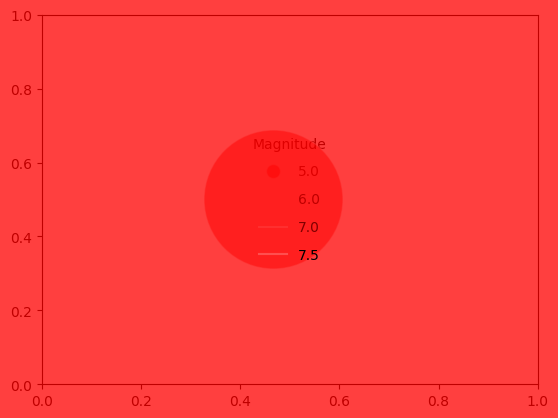

In [18]:
from matplotlib.lines import Line2D

min_marker_size = 10
min_magnitude = 5
# the four magnitudes in the legend
mags = np.array([5, 6, 7, quakes['mag'].max()])
marker_sizes = min_marker_size * (10 ** (mags - min_magnitude))

def get_legend_elements(marker_sizes):
    # marker size for each magnitude
    marker_opts = dict(marker="o", color="w", markerfacecolor="red", alpha=0.5)
    legend_elements = [
        Line2D(
            [0],
            [i],
            label=mags[i],
            markersize=s,
            **marker_opts
        )
        for i, s in enumerate(marker_sizes)
    ]
    return legend_elements

fig, ax = plt.subplots()
legend_opts = dict(title="Magnitude", labelspacing=1, frameon=False)
ax.legend(handles=get_legend_elements(marker_sizes), **legend_opts, loc='center')

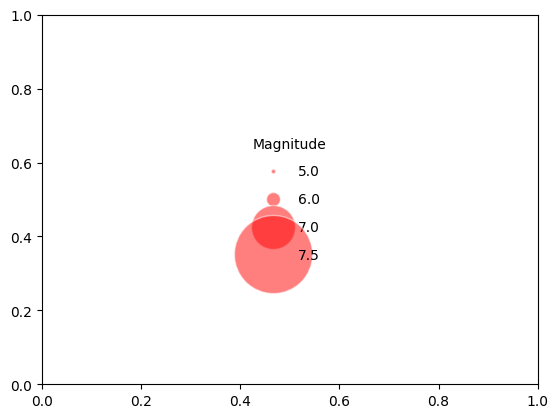

In [19]:
# marker size for each magnitude
marker_sizes = np.sqrt(min_marker_size * (10 ** (mags - min_magnitude)))

fig, ax = plt.subplots()
ax.legend(
    handles=get_legend_elements(marker_sizes),
    loc="center",
    title="Magnitude",
    labelspacing=1,
    frameon=False
)
plt.show()

In [ ]:
fig, ax = plt.subplots(layout="constrained", figsize=(7,5))
ax.set(xlim=[minlongitude, maxlongitude], ylim=[minlatitude, maxlatitude])
ax.set_title("The 2024 Japan earthquake and its aftershocks")
cx.add_basemap(ax, crs=quakes.crs, zoom=8, source="CartoDB.Voyager")

points = ax.scatter(
    quakes["longitude"].iloc[0],
    quakes["latitude"].iloc[0],
    s=quakes["marker_size"].iloc[0],
    **points_opts
)

label = ax.text(
    0.25,
    0.95,
    quakes["time"].iloc[0].strftime("%Y-%m-%d %H:%M"),
    **label_opts
)

ax.legend(
    handles=get_legend_elements(marker_sizes),
    loc="center left",
    title="Magnitude",
    labelspacing=1,
    frameon=False,
    bbox_to_anchor=(1.05, 0.5), # place the legend to the right
)

ani = animation.FuncAnimation(
    fig=fig, func=update, frames=len(quakes), interval=600
)

# To save the animation using Pillow as a gif
writer = animation.PillowWriter(fps=15, bitrate=1800)
ani.save(output_path+"/japan_animated-scatter-v2.gif", writer=writer)

plt.ioff
plt.close()